In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import numpy as np
import math
import warnings
from IPython.display import display, HTML

%matplotlib inline  
sns.set(font_scale=1.3)

# scipy doesn't include a two-sided two-proportion z-test, so include some code that does that.
from ztests import *

# Human Resources Analytics
This notebook investigates the question, are our employees leaving prematurely? The data set is from https://www.kaggle.com/ludobenistant/hr-analytics. There are 14999 data points. There is one line per employee. Fields in the dataset include:

* Satisfaction Level
* Last evaluation - I think that this is a performance metric of the employee
* Number of projects
* Average monthly hours
* Time spent at the company
* Whether they have had a work accident
* Whether they have had a promotion in the last 5 years
* Departments
* Salary
* Whether the employee has left.

## Summary of contents

* [Loading of the data and initial exploration](#init) - The training set is loaded and sample data is displayed. Pairwise correlations of numerical variables and some summary statistics are displayed. Finally, continuous variables are plotted pairwise, as are some stacked bar charts of discrete variables vs number of leavers.
* [Clustering and investigation](#cluster) - There appeared to be three groups of leavers based on the preliminary analysis. We will use a KMeans clustering algorithm to group them. In the second part we'll try and learn about the groups.
* [Conclusions](#conclusions) - There appeared to be three groups of leavers based on the preliminary analysis. We will use a KMeans clustering algorithm to group them. In the second part we'll try and learn about the groups.


## Loading of the data and initial exploration <a class="anchor" id="init"></a>

In [3]:
# Load training data into a data frame. 
input_filename = "HR_comma_sep.csv"
df = pd.read_csv(input_filename) 

#Output some sample data
display(df.head())

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
#Output some information
display(df.describe())

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


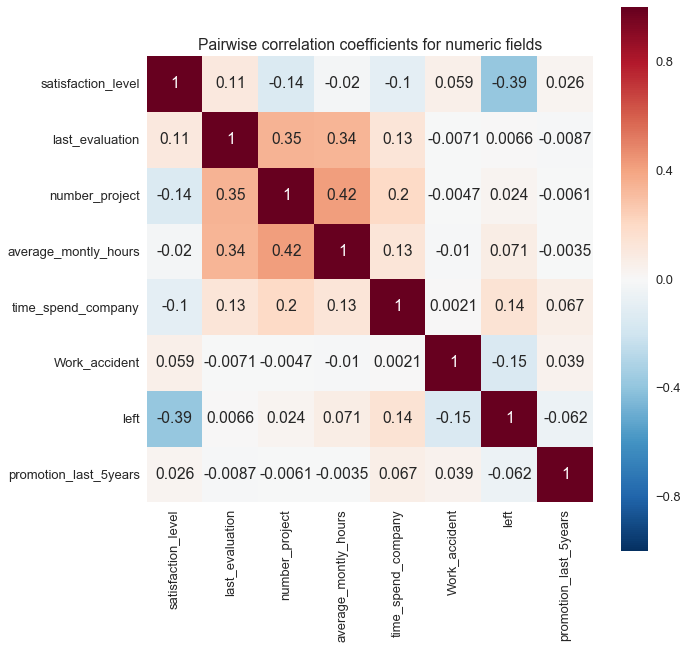

In [5]:
#Display pairwise correlations
fig, ax = plt.subplots(figsize=(10,10)) 
g = sns.heatmap(df.corr(), square=True, annot = True);
g.set_title('Pairwise correlation coefficients for numeric fields');

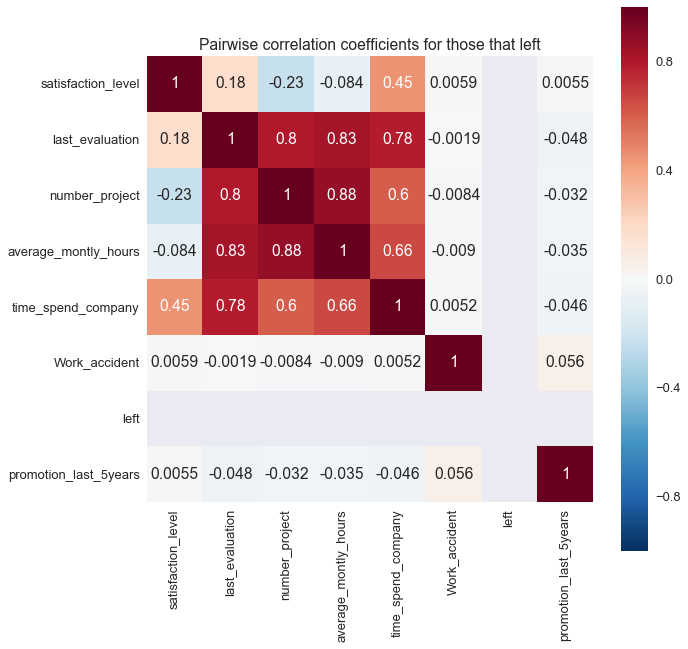

In [6]:
# Lets look at the pairwise correllations for those that left
fig, ax = plt.subplots(figsize=(10,10)) 
g = sns.heatmap(df[df['left']==1].corr(), square=True, annot = True);
g.set_title('Pairwise correlation coefficients for those that left');

Perhaps not surprisingly, there is a strong negative correlation between satisfaction and leaving the company. Let's do a pair plot of suitable to try and see any trends. First we'll convert salary to an integer value so that it can be part of the pair plot.

In [7]:
df['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [8]:
df['salary'] = df['salary'].replace({'low':1,'medium':2,'high':3})

df['salary'].head()

0    1
1    2
2    2
3    1
4    1
Name: salary, dtype: int64

### Continuous variable exploration

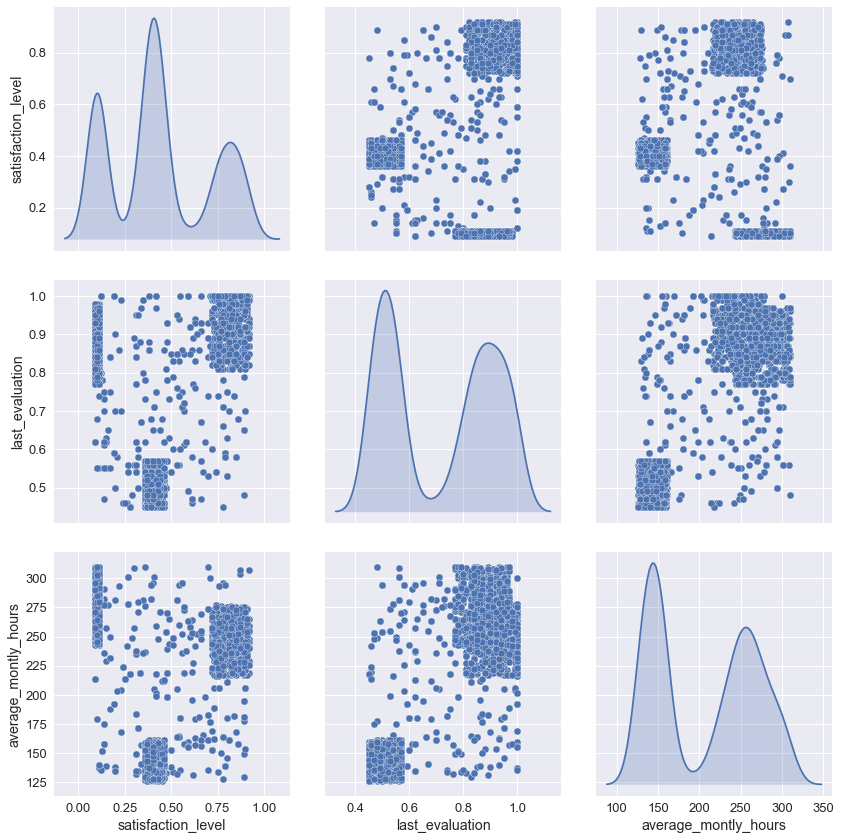

In [9]:
#Do a pairplot of the continuous variables. Only show those that left since that's what we care about.
g = sns.pairplot(df[df["left"] == 1], 
                 vars=['satisfaction_level','last_evaluation', 'average_montly_hours'], 
                 size=4, 
                 diag_kind="kde",
                 diag_kws=dict(shade=True)
                 );


There is clear clustering of the leavers here! More on that later on. Let's look at the continuous data in some other ways.

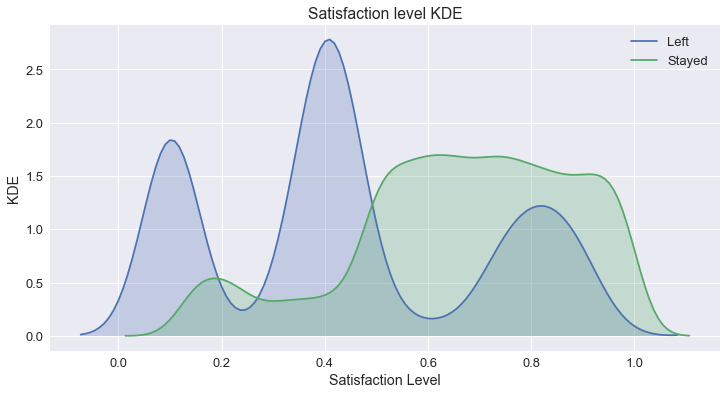

In [10]:
# Look at a kernel density estimate of the satisfaction level for each group.
fig, ax = plt.subplots(figsize=(12,6)) 
for left in df['left'].unique():
    g = sns.kdeplot(df[df['left'] == left]['satisfaction_level'], shade=True, ax=ax);

plt.title('Satisfaction level KDE');
plt.xlabel('Satisfaction Level');
plt.ylabel('KDE');
plt.legend(['Left','Stayed']);

OK. So most people that stay are reasonably satisfied. Those that leave are often grossly unsatisfied (rating around 0.1) or unsatisfied (rating around 0.4), but there is a cohort that is quite satisfied (rating around 0.8).

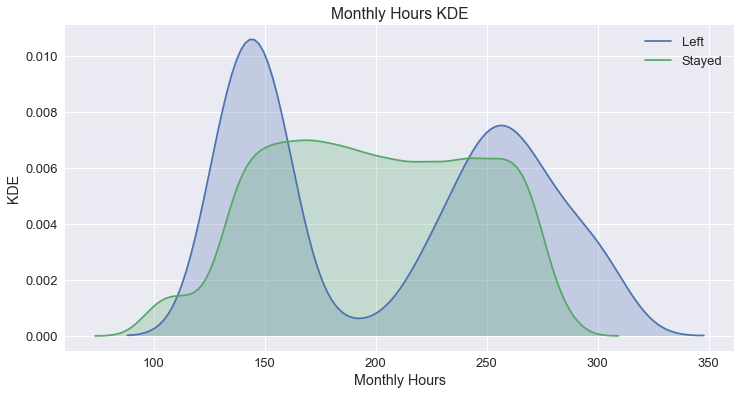

In [11]:
# Look at a kernel density estimate of the average monthly hours for each group.

fig, ax = plt.subplots(figsize=(12,6)) 
for left in df['left'].unique():
    g = sns.kdeplot(df[df['left'] == left]['average_montly_hours'], shade=True, ax=ax);

plt.title('Monthly Hours KDE');
plt.xlabel('Monthly Hours');
plt.ylabel('KDE');
plt.legend(['Left','Stayed']);

Clearly, too many monthly hours or not many hours doesn't bode well for the chances of leaving! We know that this quantity is positively correlated with the number of projects and the staff evaluation score, but too much is probably causing staff burn out.

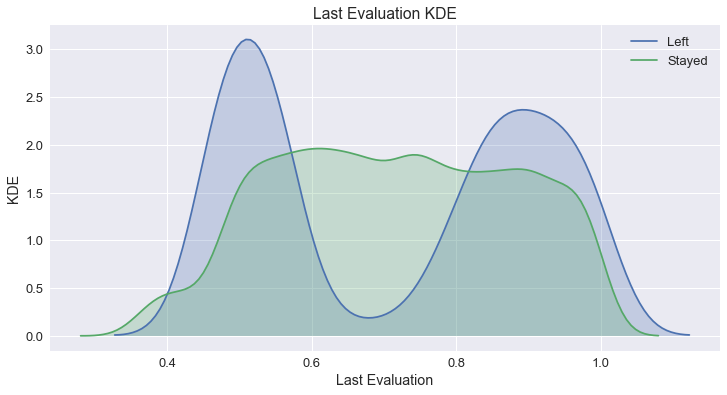

In [12]:
# Look at a kernel density estimate of the last evaluation for each group.

fig, ax = plt.subplots(figsize=(12,6)) 
for left in df['left'].unique():
    g = sns.kdeplot(df[df['left'] == left]['last_evaluation'], shade=True, ax=ax);

plt.title('Last Evaluation KDE');
plt.xlabel('Last Evaluation');
plt.ylabel('KDE');
plt.legend(['Left','Stayed']);

This is really similar to the monthly hours graph. Not surprising because we saw that the two were significantly correllated for people that left. Let's plot those two variables again.

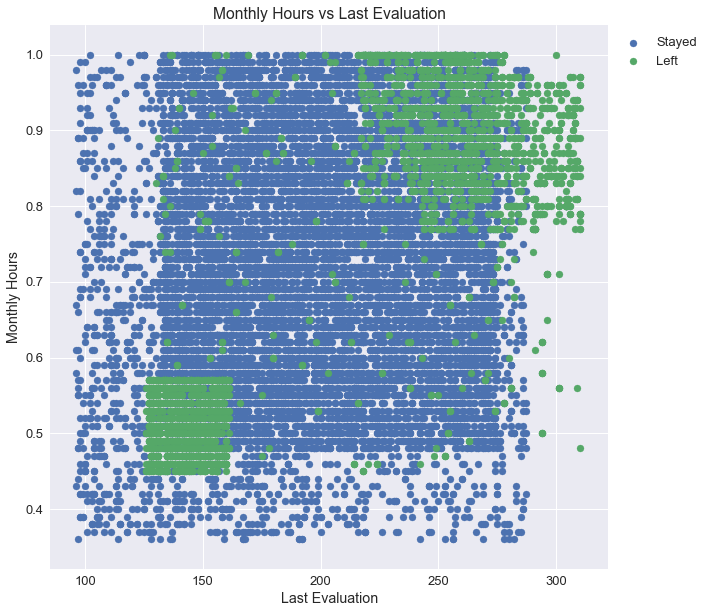

In [13]:
# Look at a kernel density estimate of the average monthly hours for each group.

fig, ax = plt.subplots(figsize=(10,10)) 
for left in np.sort(df['left'].unique()):
    plt.scatter(df[df['left']==left]['average_montly_hours'], df[df['left']==left]['last_evaluation']);
    

plt.title('Monthly Hours vs Last Evaluation');
plt.xlabel('Last Evaluation');
plt.ylabel('Monthly Hours');
plt.legend(['Stayed','Left'],bbox_to_anchor=(1, 1));

Hence groups that leave either do a lot of hours and get good evaluations, or don't do many hours and get poor evaluations.

### Discrete variables

Null hypothesis: Those that have accidents and those that don't are equally likely to stay.
The null hypothesis was rejected (p = 0.0)


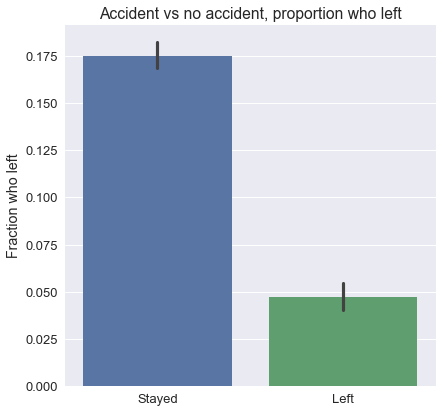

In [39]:
f, ax = plt.subplots(figsize=(6.65,6.65))
g = sns.barplot(x="left", y='Work_accident', data=df); #use the next two colours
ax.set_title("Accident vs no accident, proportion who left");
g.set_xlabel('');
g.set_ylabel('Fraction who left');
g.set_xticklabels(["Stayed", "Left"]);

# Check for statistical significance
print("Null hypothesis: Those that have accidents and those that don't are equally likely to stay.")
[statistic, pvalue] = twoPropZTtestData(df[df['left']==1]['Work_accident'], df[df['left']==0]['Work_accident'])

if(pvalue < 0.05):
    # The null wasn't rejected!
    print("The null hypothesis was rejected (p = "+str(pvalue)+")")
else:
    print("The null hypothesis was NOT rejected (p = "+str(pvalue)+")")


Clearly, workers that stayed were more likely to have had an accident. The difference is statistically significant.

Null hypothesis: Those that leave have the same mean promotion rate as those that don't.
The null hypothesis was rejected (p = 0.0)


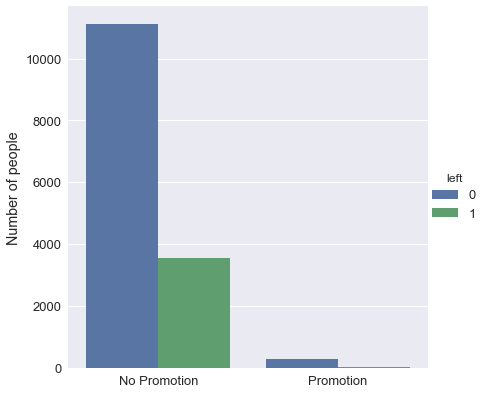

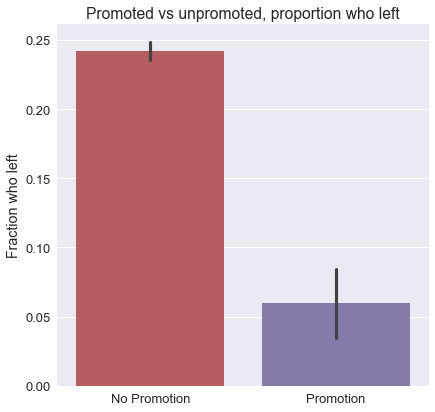

In [42]:
g = sns.factorplot(x='promotion_last_5years', hue='left', data=df, kind="count", size=6)
g.set_xticklabels(["No Promotion", "Promotion"]);
g.set_axis_labels("", "Number of people");

#We'll also plot proportion of leavers since there are only a few people that got promoted and the proportion isn't clear there.
f, ax = plt.subplots(figsize=(6.65,6.65))
g = sns.barplot(x='promotion_last_5years', y="left", data=df, palette=sns.color_palette()[2:4]); #use the next two colours
ax.set_title("Promoted vs unpromoted, proportion who left");
g.set_xlabel('');
g.set_ylabel('Fraction who left');
g.set_xticklabels(["No Promotion", "Promotion"]);


# Check for statistical significance
print("Null hypothesis: Those that leave have the same mean promotion rate as those that don't.")
[statistic, pvalue] = twoPropZTtestData(df[df['left']==1]['promotion_last_5years'], df[df['left']==0]['promotion_last_5years'])

if(pvalue < 0.05):
    # The null wasn't rejected!
    print("The null hypothesis was rejected (p = "+str(pvalue)+")")
else:
    print("The null hypothesis was NOT rejected (p = "+str(pvalue)+")")


Also not surprisingly, those who are not promoted are more likely to leave. The difference is statistically significant.

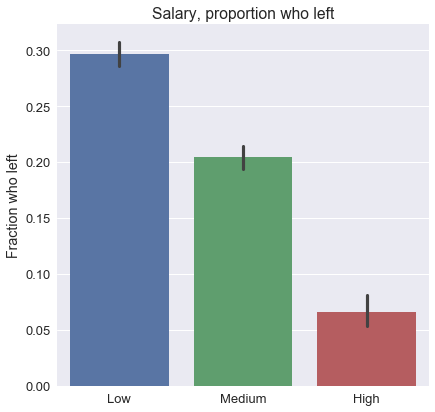

In [16]:
f, ax = plt.subplots(figsize=(6.65,6.65))
g = sns.barplot(x='salary', y="left", data=df); #use the next two colours
ax.set_title("Salary, proportion who left");
g.set_xlabel('');
g.set_ylabel('Fraction who left');
g.set_xticklabels(["Low", "Medium", "High"]);

In [45]:
#Significance testing
tab = pd.crosstab(df['salary'],df['left'])
print("Null hypothesis: Survival proportion is the same for each salary group.")

chi2, pvalue, dof, ex = stats.chi2_contingency(tab.values)

if(pvalue <= 0.05):
    # Reject the null!
    print("Null hypothesis was rejected. pvalue:",pvalue)
else:
    # Accept the null
    print("Null hypothesis was NOT rejected. pvalue:",pvalue)
    

Null hypothesis: Survival proportion is the same for each salary group.
Null hypothesis was rejected. pvalue: 1.6520867493e-83


Once again, not suprisingly, there are statistically significant differences in leave rate depending on the salary. We could do pairwise signficance testing now, controlling for the multiple comparisons problem. But let's leave it at that at look at the leave rate vs the number of projects.

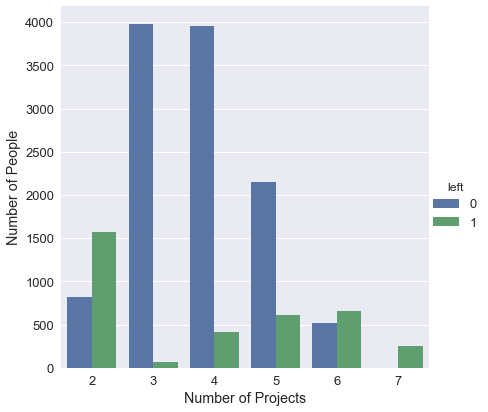

In [17]:
g = sns.factorplot(x='number_project', hue='left', data=df, kind="count", size=6)
g.set_axis_labels("Number of Projects", "Number of People");

It looks as though too many or not enough projects cause attrition. More on that in the next section.

## Clustering and investigation  <a class="anchor" id="cluster"></a>

In the previous section, we noticed that there was some clear clustering going on with leavers. For example, looking at the satisfaction level vs last evaluation variables for those that left, we have:

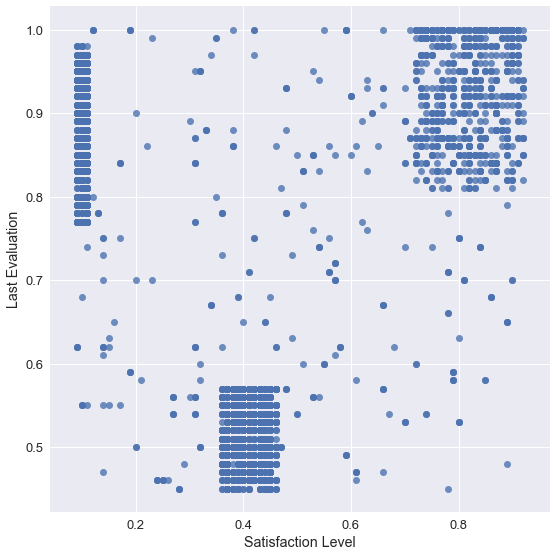

In [18]:
g = sns.lmplot('satisfaction_level', 'last_evaluation', data=df[df["left"] == 1], fit_reg=False, scatter=True, size=8);
g.set_axis_labels("Satisfaction Level", "Last Evaluation");

Now we will try to cluster the data into three groups. We'll just use the continuous variables because they seperate the groups well. We know there are three groups, so we'll use a KMeans algorithm. 

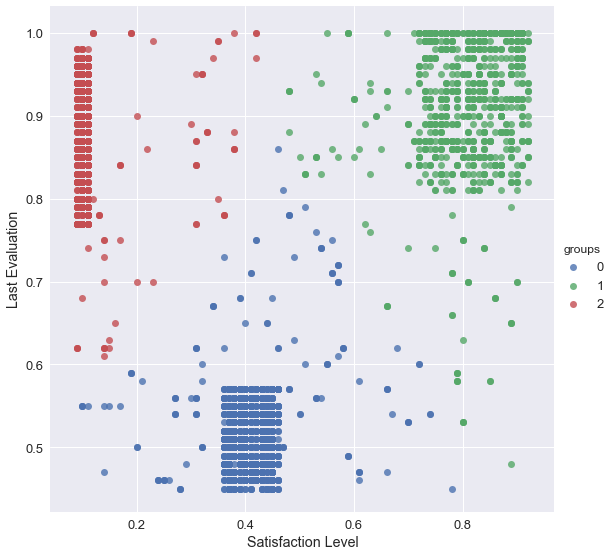

In [19]:
from sklearn import cluster
left = df[df["left"] == 1].reindex()

kmeans = cluster.KMeans(n_clusters=3);
kmeans_groups = kmeans.fit_predict( left[['satisfaction_level', 'last_evaluation']]);
left['groups'] = kmeans_groups

g = sns.lmplot('satisfaction_level', 'last_evaluation', hue='groups', data=left, fit_reg=False, scatter=True, size=8);
g.set_axis_labels("Satisfaction Level", "Last Evaluation");

Let's check if our groups capture the two hours worked/last evaluation groups we saw before.

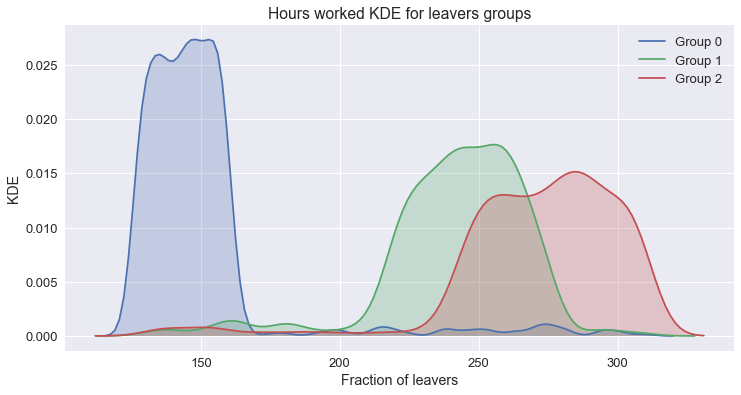

In [20]:
# Look at a kernel density estimate of the leavers to get a feel for the number of hours worked for each group.
fig, ax = plt.subplots(figsize=(12,6)) 
for group in left['groups'].unique():
    g = sns.kdeplot(left[left['groups'] == group]['average_montly_hours'], shade=True, ax=ax);

plt.title('Hours worked KDE for leavers groups');
plt.xlabel('Fraction of leavers');
plt.ylabel('KDE');
plt.legend(['Group 0','Group 1','Group 2']);

Yes. Clustering this way does catch both hours worked (and hence last evaluation) groups. No need to segment further. Let's see what other factors are important except hours worked.

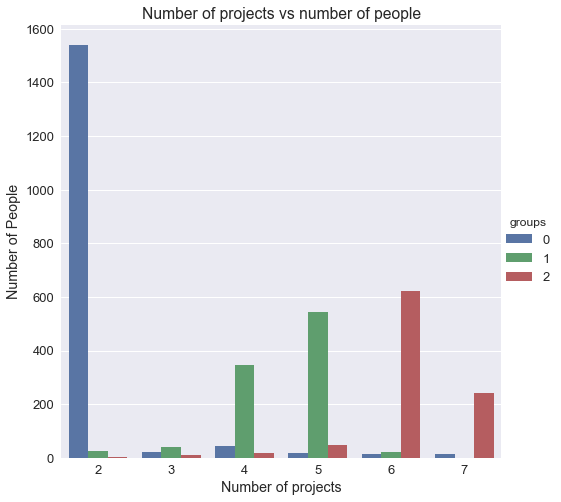

In [21]:
g = sns.factorplot(x='number_project', hue='groups', data=left, kind="count", size=7)
g.set_axis_labels("Number of projects", "Number of People");
ax = g.axes.flatten()[0];
ax.set_title("Number of projects vs number of people");

It's pretty clear that number of projects is a proxy for the information from the hours worked here. Let's look at satisfaction level.

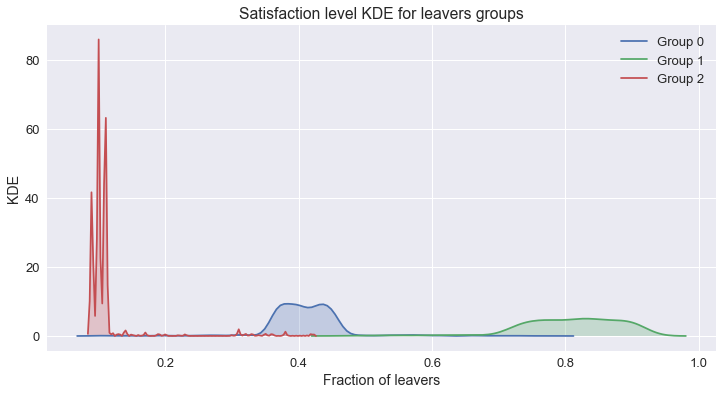

In [22]:
# Look at a kernel density estimate of the leavers to get a feel for the satisfaction level for each group.
fig, ax = plt.subplots(figsize=(12,6)) 
for group in left['groups'].unique():
    g = sns.kdeplot(left[left['groups'] == group]['satisfaction_level'], shade=True, ax=ax);

plt.title('Satisfaction level KDE for leavers groups');
plt.xlabel('Fraction of leavers');
plt.ylabel('KDE');
plt.legend(['Group 0','Group 1','Group 2']);

We see three very distinct groups on this axis. We still haven't found a good explination for why group 1 is leaving. Let's look at the promotion rate and accident rate in the same evaluation/satisfaction cluster for the whole data set.

In [27]:
#predict the group for the whole dataset based on what the trained for those leaving
kmeans_groups = kmeans.predict( df[['satisfaction_level', 'last_evaluation']])
df['groups'] = kmeans_groups

#g = sns.lmplot('satisfaction_level', 'last_evaluation', hue='groups', data=df, fit_reg=False, scatter=True, size=8);
#g.set_axis_labels("Satisfaction Level", "Last Evaluation");

#Look at the mean promotion rate in those that left and those that didn't in group 1.
stayed = df[df['left']==0];

stayed_and_promoted = stayed[stayed['groups']==1]['promotion_last_5years']
left_and_promoted = left[left['groups']==1]['promotion_last_5years']

print("Group 1 promotion rate (stayed):",stayed_and_promoted.mean())
print("Group 1 promotion rate (left):",left_and_promoted.mean())



# Check for statistical significance
print("Null hypothesis: The mean promotion rate of those who stayed and left in group 1 are the same.")
[statistic, pvalue] = twoPropZTtestData(stayed_and_promoted, left_and_promoted)

if(pvalue < 0.05):
    # The null wasn't rejected!
    print("The null hypothesis was rejected (p = "+str(pvalue)+")")
else:
    print("The null hypothesis was NOT rejected (p = "+str(pvalue)+")")


Group 1 promotion rate (stayed): 0.026368586987675552
Group 1 promotion rate (left): 0.0040941658137154556
Null hypothesis: The mean promotion rate of those who stayed and left in group 1 are the same.
The null hypothesis was rejected (p = 0.0)


Clearly, Group 1 has good performance, but those that aren't being promoted are perhaps leaving before they should. The difference in promotion rate between the two groups is statistically significant. Let's look at accident rate.

In [38]:
stayed_and_accident = stayed['Work_accident']
left_and_accident = left['Work_accident']

print("Group 1 accident rate (stayed):",stayed_and_accident.mean())
print("Group 1 accident rate (left):",left_and_accident.mean())

# Check for statistical significance
print("Null hypothesis: The mean promotion rate of those who stayed and left in group 1 are the same.")
[statistic, pvalue] = twoPropZTtestData(stayed_and_accident, left_and_accident)

if(pvalue < 0.05):
    # The null wasn't rejected!
    print("The null hypothesis was rejected (p = "+str(pvalue)+")")
else:
    print("The null hypothesis was NOT rejected (p = "+str(pvalue)+")")


Group 1 accident rate (stayed): 0.17500875043752187
Group 1 accident rate (left): 0.047325679081489776
Null hypothesis: The mean promotion rate of those who stayed and left in group 1 are the same.
The null hypothesis was rejected (p = 0.0)


People who stayed were actually more likely to have had an accident in this cohort, but we saw that for the entire dataset too.

## Conclusions <a class="anchor" id="conclusionsr"></a>

* Too many hours or not enough hours make people likely to leave. The number of hours is related to the number of projects. More hours worked improves the performance rating.
* People who have accidents are less likely to leave.
* Group 0 isn't too unhappy, but they aren't working on many projects or spending many hours working. If possible, their workload should be increased.
* Group 1 is very satisfied and not working too much. The leavers group is statistically less likely to have been promoted than similarly satisfied and performing workers. A higher promotion rate would likely reduce the attrition rate. 
* Group 2 is grossly unhappy, probably because they are overworked. The best course of action is to reduce their workload.